# PROBLEMA 4: **Clasificación de Especies de Aves con Naive Bayes**  

### Entrega: Daniel Rojo Mata

## **Enunciado del problema**  

Un equipo de biólogos está estudiando **dos especies de aves** que habitan en una región montañosa. Estas especies tienen **preferencias distintas** por ciertas condiciones ambientales, lo que influye en su distribución geográfica.  

Para caracterizar los lugares donde han sido observadas, los investigadores registran las siguientes variables:  
- **x1:** Temperatura media del hábitat (°C)  
- **x2:** Altitud relativa del hábitat (m)  
- **y:** Especie  

Descarga el conjunto de datos de especies de aves disponible en [este enlace](http://turing.iimas.unam.mx/~gibranfp/cursos/aprendizaje_automatizado/data/aves.csv) y realiza lo siguiente:  

### **1. Entrenamiento del clasificador:**  
   - Entrena un **clasificador Naive Bayes Gaussiano** utilizando las características ambientales registradas.  

### **2. Evaluación del modelo:**  
   - Evalúa el clasificador en el **conjunto de entrenamiento**, calculando el **porcentaje de aciertos**.  

### **3. Visualización y análisis:**  
   - **Visualiza los datos** mediante gráficos adecuados.  
   - **Muestra la frontera de decisión** del clasificador.  
   - **Calcula y analiza la matriz de confusión** para evaluar el rendimiento del modelo.  
   - Discute los resultados obtenidos y el desempeño del clasificador.  

## **Descripción del conjunto de datos**  
El archivo `aves.csv` contiene observaciones de dos especies de aves registradas en distintos hábitats. Cada fila representa un hábitat específico y está descrita por:  
- **Temperatura media (x1):** Expresada en grados Celsius.  
- **Altitud relativa (x2):** Medida en metros.  
- **Especie (y):** Indica a qué especie pertenece la observación.  


# **Solución**:

### Librerías

In [17]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Clasificador Gaussiano

In [2]:
class NaiveBayesGaussiano:
    def __init__(self):
        """
        Inicializa los atributos del modelo de Naive Bayes con distribución Gaussiana.
        """
        self.media = None  # Media de cada característica por clase
        self.desviacion = None  # Desviación estándar de cada característica por clase
        self.proba_clase = None  # Probabilidad a priori de cada clase
        self.clases = None  # Clases únicas en el conjunto de datos
        self.epsilon = 1e-6  # Pequeño valor para evitar divisiones por 0 en la varianza

    def fit(self, X_ent, y_ent):
        """
        Entrena el modelo con el conjunto de entrenamiento.
        Calcula los parámetros de la distribución Gaussiana (media y desviación estándar) 
        para cada característica en cada clase.
        
        Parámetros:
            X_ent: ndarray de forma (num_muestras, num_características), matriz de datos de entrada.
            y_ent: ndarray de forma (num_muestras,), vector de etiquetas de clase.
        """
        self.clases = np.unique(y_ent)  # Obtiene las clases únicas en el conjunto de entrenamiento
        num_clases = len(self.clases)  # Número total de clases
        num_caracteristicas = X_ent.shape[1]  # Número de características en los datos
        
        # Inicializa matrices para almacenar la media, desviación estándar y probabilidades a priori, resp.
        self.media = np.zeros((num_clases, num_caracteristicas))
        self.desviacion = np.zeros((num_clases, num_caracteristicas))
        self.proba_clase = np.zeros(num_clases)
        
        # Itera sobre cada clase para calcular sus parámetros estadísticos
        for i, clase in enumerate(self.clases):
            X_clase = X_ent[y_ent == clase]  # Filtra las muestras que pertenecen a la clase actual
            self.media[i, :] = X_clase.mean(axis=0)  # Calcula la media de cada característica
            self.desviacion[i, :] = np.maximum(X_clase.std(axis=0), self.epsilon)  # Evita sigma = 0
            self.proba_clase[i] = len(X_clase) / len(X_ent)  # Calcula la probabilidad a priori de la clase

    def gaussian_log(self, x, mu, sigma):
        """
        Calcula la densidad de probabilidad de una distribución Gaussiana para cada característica.

        Parámetros:
            x: ndarray de forma (num_muestras, num_características), valores de entrada.
            mu: ndarray de forma (num_características,), media de la distribución Gaussiana.
            sigma: ndarray de forma (num_características,), desviación estándar de la distribución Gaussiana.

        return:
            Log-probabilidad de cada característica bajo la distribución Gaussiana correspondiente.
        """
        sigma = np.maximum(sigma, self.epsilon)  # Asegura que sigma no sea 0 para evitar errores numéricos
        coef = -0.5 * np.log(2 * np.pi * sigma**2)  # Cálculo del coeficiente de normalización en logaritmo
        exponente = -((x - mu) ** 2) / (2 * sigma ** 2)  # Cálculo de la parte exponencial de la función Gaussiana
        return coef + exponente  # Retorna la suma de log-probabilidades para estabilidad numérica

    def calcular_probabilidades_posteriores(self, X):
        """
        Calcula las probabilidades logarítmicas de cada clase para cada muestra.

        Parámetros:
            X: ndarray de forma (num_muestras, num_características), datos de entrada.

        return:
            log_probabilidades: ndarray de forma (num_muestras, num_clases),
                                matriz de log-probabilidades de cada muestra perteneciendo a cada clase.
        """
        num_muestras = X.shape[0]  # Número total de muestras
        num_clases = len(self.clases)  # Número total de clases
        log_probabilidades = np.zeros((num_muestras, num_clases))  # Inicializa matriz de log-probabilidades
        
        # Itera sobre cada clase para calcular la log-probabilidad de que una muestra pertenezca a ella
        for i in range(num_clases):
            log_prob_verosimilitud = self.gaussian_log(X, self.media[i, :], self.desviacion[i, :])  
            log_prob_verosimilitud = np.sum(log_prob_verosimilitud, axis=1)  # Suma las log-probabilidades de cada característica
            
            # Aplica la fórmula de la probabilidad posterior en logaritmo:
            # log P(C|X) = log P(X|C) + log P(C), sin dividir por P(X) ya que no afecta la clasificación
            log_probabilidades[:, i] = log_prob_verosimilitud + np.log(self.proba_clase[i]) 
        
        return log_probabilidades  # Retorna la matriz de log-probabilidades para cada muestra y clase

    def predict(self, X):
        """
        Predice la clase de cada muestra en X.

        Parámetros:
            X: ndarray de forma (num_muestras, num_características), datos de entrada.

        return:
            Un vector con las clases predichas para cada muestra.
        """
        log_probabilidades = self.calcular_probabilidades_posteriores(X)  # Calcula log-probabilidades para cada clase
        return self.clases[np.argmax(log_probabilidades, axis=1)]  # Retorna la clase con mayor log-probabilidad para cada muestra

## Procesamiento de la data 

In [3]:
# Cargar la data
archivo = "aves.csv"
data = pd.read_csv(archivo, index_col=0)

In [4]:
# Separar características y etiquetas
X = data.iloc[: , : -1].to_numpy()
y = data.iloc[:, -1].to_numpy()

## Visualización de la data

### Distribución de especies

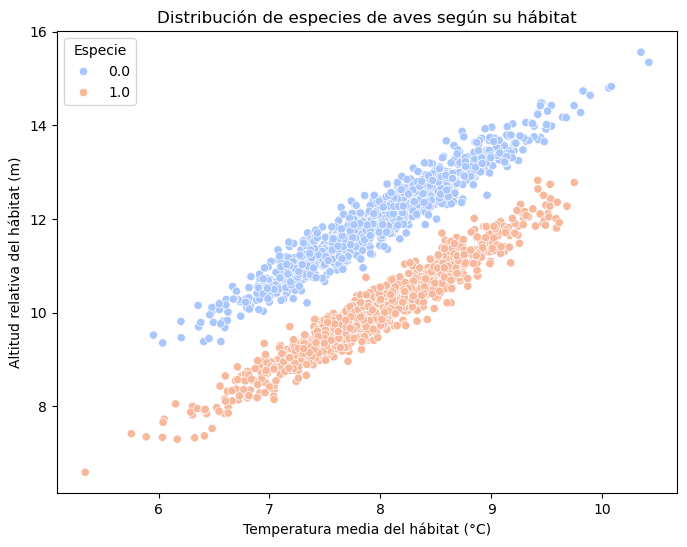

In [5]:
# Visualizar la distribución de las especies en el espacio de características
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='coolwarm', alpha=1)
plt.xlabel("Temperatura media del hábitat (°C)")
plt.ylabel("Altitud relativa del hábitat (m)")
plt.title("Distribución de especies de aves según su hábitat")
plt.legend(title="Especie")
plt.show()

### Histogramas 

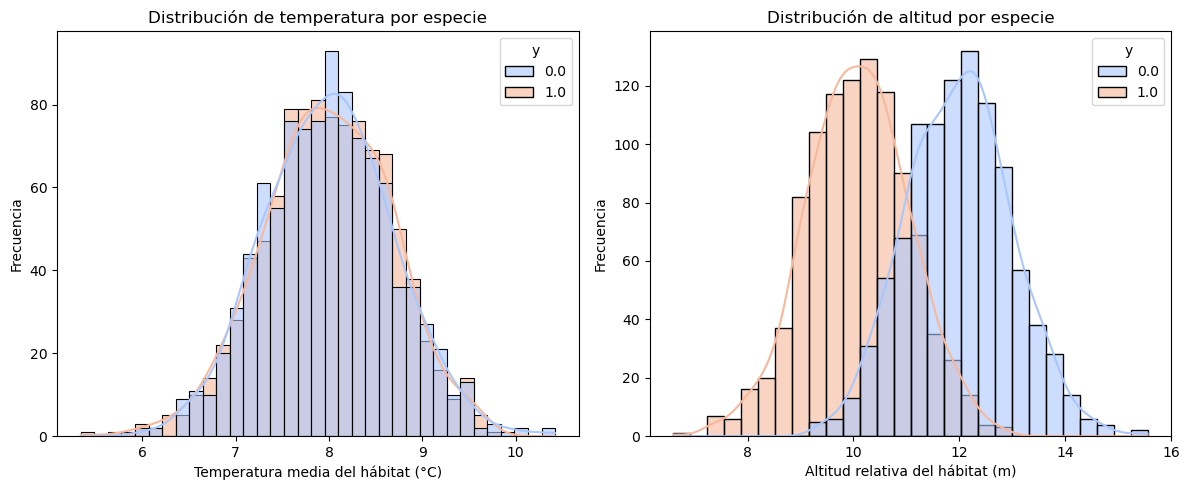

In [6]:
plt.figure(figsize=(12, 5))

# Histograma para la temperatura
plt.subplot(1, 2, 1)
sns.histplot(data, x="x1", hue="y", kde=True, palette="coolwarm", alpha=0.6)
plt.xlabel("Temperatura media del hábitat (°C)")
plt.ylabel("Frecuencia")
plt.title("Distribución de temperatura por especie")

# Histograma para la altitud
plt.subplot(1, 2, 2)
sns.histplot(data, x="x2", hue="y", kde=True, palette="coolwarm", alpha=0.6)
plt.xlabel("Altitud relativa del hábitat (m)")
plt.ylabel("Frecuencia")
plt.title("Distribución de altitud por especie")

plt.tight_layout()
plt.show()

## División del conjunto de datos

In [7]:
# Dividir en conjunto de entrenamiento (60%) y el resto (40%)
X_ent, X_temp, y_ent, y_temp = train_test_split(X, y, test_size=0.4, random_state=0)

# Dividir el conjunto temporal en validación (20%) y prueba (20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

# Ver las dimensiones de los conjuntos anteriores
print(f'Tamaño del conjunto de entrenamiento: {X_ent.shape}')
print(f'Tamaño del conjunto de validación: {X_val.shape}')
print(f'Tamaño del conjunto de prueba: {X_test.shape}')

Tamaño del conjunto de entrenamiento: (1200, 2)
Tamaño del conjunto de validación: (400, 2)
Tamaño del conjunto de prueba: (400, 2)


## Resultados con clasificador Gaussiano

In [8]:
# Crear una instancia de NaiveBayesGaussiano
nb_gauss = NaiveBayesGaussiano()

# Entrenar el clasificador con los datos de entrenamiento
nb_gauss.fit(X_ent, y_ent)

# Predecir para los conjuntos de datos
predicciones_ent = nb_gauss.predict(X_ent)
predicciones_val = nb_gauss.predict(X_val)
predicciones_test = nb_gauss.predict(X_test)

# Calcular la precisión (accuracy)
accuracy_ent_gaussiano = accuracy_score(y_ent, predicciones_ent) * 100
accuracy_val_gaussiano = accuracy_score(y_val, predicciones_val) * 100
accuracy_test_gaussiano = accuracy_score(y_test, predicciones_test) * 100

# Imprimir resultados
print(f"Precisión en entrenamiento: {accuracy_ent_gaussiano:.2f}%")
print(f"Precisión en validación: {accuracy_val_gaussiano:.2f}%")
print(f"Precisión en prueba: {accuracy_test_gaussiano:.2f}%")

Precisión en entrenamiento: 83.83%
Precisión en validación: 83.25%
Precisión en prueba: 83.50%


## Resultados con SckitLearn

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Dividir los datos en entrenamiento (60%), validación (20%) y prueba (20%)
X_ent, X_temp, y_ent, y_temp = train_test_split(X, y, test_size=0.4, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

# Crear una instancia del clasificador Naive Bayes Gaussiano
nb_classifier = GaussianNB()

# Entrenar el modelo con los datos de entrenamiento
nb_classifier.fit(X_ent, y_ent)

# Predecir para los conjuntos de entrenamiento, validación y prueba
predicciones_ent = nb_classifier.predict(X_ent)
predicciones_val = nb_classifier.predict(X_val)
predicciones_test = nb_classifier.predict(X_test)

# Calcular la precisión (accuracy)
accuracy_ent = accuracy_score(y_ent, predicciones_ent) * 100
accuracy_val = accuracy_score(y_val, predicciones_val) * 100
accuracy_test = accuracy_score(y_test, predicciones_test) * 100

# Imprimir los resultados
print(f"Precisión en entrenamiento: {accuracy_ent:.2f}%")
print(f"Precisión en validación: {accuracy_val:.2f}%")
print(f"Precisión en prueba: {accuracy_test:.2f}%")

Precisión en entrenamiento: 83.83%
Precisión en validación: 83.25%
Precisión en prueba: 83.50%


## Visualizaciones 

### Frontera de decisión

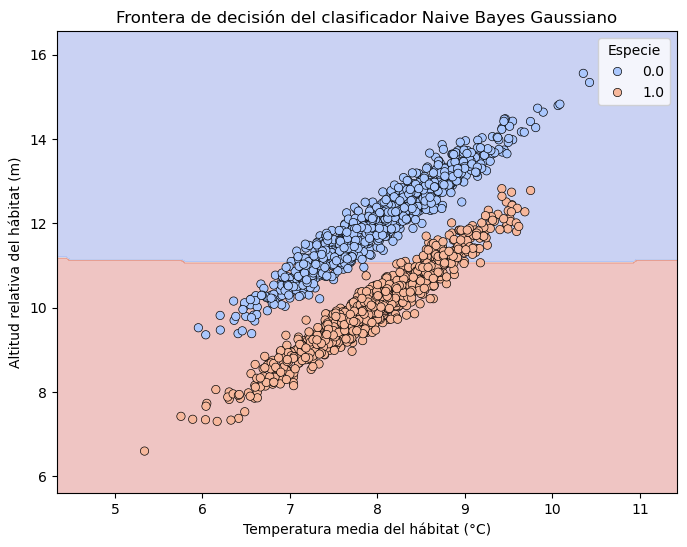

In [10]:
# Crear una malla de puntos en el espacio de características
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# Predecir sobre la malla de puntos
Z = nb_gauss.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Graficar la frontera de decisión
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='coolwarm', edgecolor="k")
plt.xlabel("Temperatura media del hábitat (°C)")
plt.ylabel("Altitud relativa del hábitat (m)")
plt.title("Frontera de decisión del clasificador Naive Bayes Gaussiano")
plt.legend(title="Especie")
plt.show()

### Matriz de confusión

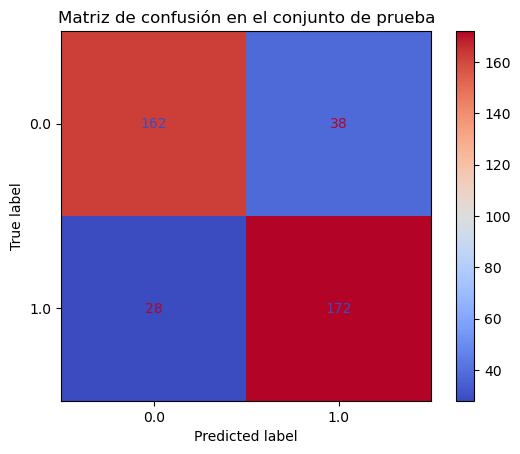

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, predicciones_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb_gauss.clases)
disp.plot(cmap="coolwarm")
plt.title("Matriz de confusión en el conjunto de prueba")
plt.show()

### Curva ROC

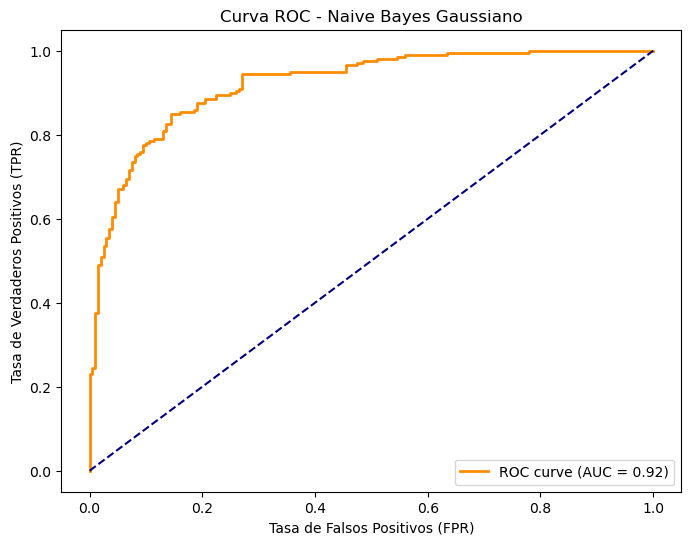

In [15]:
from sklearn.metrics import roc_curve, auc

# Obtener probabilidades de la clase positiva (asumiendo que la segunda clase es la "positiva")
probabilidades = nb_gauss.calcular_probabilidades_posteriores(X_test)
prob_clase_1 = np.exp(probabilidades[:, 1]) / np.exp(probabilidades).sum(axis=1)  # Softmax para normalizar

# Convertir etiquetas a valores numéricos si es necesario
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_test_num = le.fit_transform(y_test)  # Convierte etiquetas de clase a 0 y 1

# Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_test_num, prob_clase_1)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")  # Línea de referencia
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC - Naive Bayes Gaussiano")
plt.legend(loc="lower right")
plt.show()

## Desempeño

In [18]:
# Analizar el desempeño
print("\nAnálisis del desempeño:")
print("-" * 50)
print(f"La precisión en entrenamiento es {accuracy_ent_gaussiano:.2f}%, lo que indica qué tan bien el modelo memorizó los datos.")
print(f"La precisión en validación es {accuracy_val_gaussiano:.2f}%, usada para evaluar generalización antes de probar con datos nuevos.")
print(f"La precisión en prueba es {accuracy_test_gaussiano:.2f}%, lo que refleja el rendimiento final del modelo.")

# Evaluar si hay sobreajuste o subajuste
if accuracy_ent_gaussiano > accuracy_val_gaussiano + 5:
    print("\nEl modelo podría estar sobreajustado, ya que el desempeño en entrenamiento es mucho mejor que en validación/prueba.")
elif accuracy_val_gaussiano < 60:
    print("\nEl modelo podría estar subajustado, ya que su precisión es baja en todos los conjuntos.")
else:
    print("\nEl modelo parece tener un buen equilibrio entre ajuste y generalización.")


Análisis del desempeño:
--------------------------------------------------
La precisión en entrenamiento es 83.83%, lo que indica qué tan bien el modelo memorizó los datos.
La precisión en validación es 83.25%, usada para evaluar generalización antes de probar con datos nuevos.
La precisión en prueba es 83.50%, lo que refleja el rendimiento final del modelo.

El modelo parece tener un buen equilibrio entre ajuste y generalización.
